In [52]:
%matplotlib notebook
%pip install plotly
%precision %.3f

Note: you may need to restart the kernel to use updated packages.


'%.3f'

In [1]:
# Import Python packages needed for use in this script
import os
import glob
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import warnings
from matplotlib import colors as mcolors
from IPython.display import display, Markdown, Latex
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from scipy import interpolate
from plotly.subplots import make_subplots
import matplotlib.image as mpimg
from PIL import Image
import statistics as stats

In [2]:
# Ignore all warnings
warnings.filterwarnings('ignore')

In [34]:
# Set unlimited display for number of columns and width, but hold the number of rows to 25
pd.options.display.max_columns = None
pd.options.display.width       = None
pd.set_option('display.max_rows', 10)
pd.set_option("display.precision", 4)

In [13]:
def data_reader(filename = "D:/Wholehouse_Simulations/output.csv"):

    # Read csv into pandas dataframe
    df          = pd.read_csv(filename, low_memory=False)
    
    # Print the number of rows in the dataframe, corresponding to the number of times the Wholehouse Simulation ran
    index       = df.index
    num_rows    = len(index)
    print("The number of rows in df is:", num_rows)

    # Find out the numer of models and replicates per simulation
    columns     = df.columns
    models      = int(df[["i"]].max() + 1)
    replicates  = int(df[[" j"]].max() + 1)
    print("The number of models per simulation is", models, "and the number of replicates is", replicates, ".")

    # Formatting
    df.columns = df.columns.str.replace(' ', '')
    df = df.astype("float")
    
   # for i in df.columns:
   #     if "%" in i:
   #         df[i] = df[i].multiply(100)
   #         
    df = df.round(decimals = 5)
            
    return df

In [3]:
def input_help():

    display(Markdown('## Dataframe Input Variable List ## \n'))
    display(Markdown('## =================================================== ## \n'))
    display(Markdown('**B** = *Initial Number Infected*  \n  **Z** = *Edge Persistence*  \n  **D** = *Patient Discharge Odds*'))
    display(Markdown('**Y** = *Asymptomatic Rate*  \n  **YY** = *Asymptomatic Attenuation*  \n  **A** = *Alpha Parameter*'))
    display(Markdown('**X** = *Disease Model*  \n  **E** = *Vaccination Effectiveness*  \n  **S** = *Susceptibility*'))
    display(Markdown('**I** = *Infectivity*  \n  **W** = *Disease Incubation Period (in Days)*  \n  **T** = *Disease Infection Period (in Days)*'))
    display(Markdown('**VB** = *HCW Vaccination Budget*,  \n  **UB** = *Patient Vacination Budget*  \n  **V** = *Vaccination Rate of Patients*'))
    display(Markdown('**VO** = *Vaccination Order*  \n  **VX** = *Vaccination Order Reversal Flag*  \n  **P** = *PPE Effectiveness*'))
    display(Markdown('**VC** = *Voluntary Isolation Parameter*  \n  **VS** = *Voluntary Isolation Start Period (in Days)*  \n  **VT** = *Voluntary Isolation Term (in Days)*'))
    display(Markdown('**Q1** = *Pre-work Test Effectiveness*  \n  **Q2** = *Post-work Test Effectiveness*  \n  **QS** = *Quarantine Start Period (in Days)*'))
    display(Markdown('**QT** = *Quarantine Time Period (in Days)*  \n  **MPC** = *Multiplex Cohort Size*  \n  **MPT** = *Multiplex Threshhold*  \n  **GPL** = *Ground Patient Lag Time (in Weeks)*'))

In [4]:
def output_help():
    
    display(Markdown('## Dataframe Output Variable List ## \n'))
    display(Markdown('## =================================================== ## \n'))
    display(Markdown('**i** = *Model Number*  \n  **j** = *Replicate Number*  \n **hcw** = *Number of HCWs at Beginning of Model*'))
    display(Markdown('**pat** = *Number of Patients at Beginning of Model*  \n  **#rounds** = *Number of Iterations in Model*  \n **#totpat** = *Total Number of Patients*'))
    display(Markdown('**#tothcw** = *Total Number of HCWs*  \n  **#vacpat** = *Number of Vaccinated Patients*  \n **#vachcw** = *Number of Vaccinated HCWs*'))
    display(Markdown('**#infpat** = *Number of Infected Patients*  \n  **#infhcw** = *Number of Infected HCWs*  \n **#hcwpat** = *Number of Transmissions from HCWs to patients*'))
    display(Markdown('**#pathcw** = *Number of Transmissions from Patients to HCWs*  \n  **#hcwhcw** = *Number of Transmissions from HCW to HCW*  \n **#sickdays** = *Number of Sick Days Taken*'))
    display(Markdown('**#avglos** = *Average Length of Stay*  \n  **R0** = *Disease Transmission Rate*  \n **%pat** = *Percentage of Patients Infected*'))
    display(Markdown('**%hcw** = *Percentage of HCWs Infected*  \n  **%total** = *Percentage of Total Agents Infected*  \n  **MPS** = *Multiplexing Threshhold*'))
    display(Markdown('**npat0** = *Number of Initially Infected Patients*  \n  **nhcw0** = *Number of Initially Infected HCWs*  \n  **new_infected** = *Number of Infected Patients Entering Simulation AFTER Day 0*'))
    display(Markdown('**secondary_infect** = *Number of Secondary Infections*  \n  **first_test** = *Number of Infected HCWs Caught First Test After Incubation Period*  \n  **first_day** = *Number of Infected HCWs Caught on First Day After Incubation Period*'))
    display(Markdown('**sum_days_sym** = *Sum of Days Symptomatic HCWs Spend in Simulation*  \n  **hcw_infected** = *Number of HCWs Infected by Other HCWs Who Have Passed the Incubation Period*  \n  **pat_infected** = *Number of Patients Infected by Other HCWs Who Have Passed the Incubation Period*'))
    display(Markdown('**%first_test** = *Percentage of HCWs Caught on First Test Compared to All HCWs Who Made the First Day*  \n  **%first_day** = *Percentage of HCWs Caught on First Day Compared to All HCWs Who Made the First Day*  \n  **sum_days_all** = *Total Number of Days Spent by All HCWs in Simulation*  \n  **%infectivity** = *Percentage of Total Infectivity of HCWs That Was Caught*'))

In [5]:
def rep_means(df):
    
    index      = df.index
    num_rows   = len(index)

    columns    = df.columns
    replicates = int(df[["j"]].max() + 1)

    N          = replicates*np.ones(int(len(index)/(replicates)))
    df2        = pd.DataFrame(N, columns = ["N"])
    #models     = list(set(df["i"]))

    for i in range(2, len(columns)):

            total           = df[columns[i]].tolist()
            chunks          = [total[x:x+replicates] for x in range(0, len(total), replicates)]
            chunks          = np.array(chunks)
            chunks          = chunks.astype("float")   
            avgs            = np.mean(chunks, axis = 1)

            df2[columns[i]] = avgs 
    
    models = np.linspace(0, len(df2)-1, len(df2))
    df2.insert(0, "#Model", models)
    
    df2 = df2.round(decimals = 4)
            
    return df2

In [6]:
def sim_means(df):

    columns    = df.columns
    index      = df.index
    models     = int(df[["i"]].max() + 1)
    replicates = int(df[["j"]].max() + 1)
    #print("The number of models per simulation in df is", models, "and the number of replicates is", replicates, ".")

    N          = models*replicates*np.ones(int(len(index)/(models*replicates)))
    df2        = pd.DataFrame(N, columns = ["N"])

    for i in range(2, len(columns)):

            total           = df[columns[i]].tolist()
            chunks          = [total[x:x+models*replicates] for x in range(0, len(total), models*replicates)]
            chunks          = np.array(chunks)
            chunks          = chunks.astype("float")
            avgs            = np.mean(chunks, axis = 1)

            df2[columns[i]] = avgs 
            df2.columns     = df2.columns.str.replace(' ', '')
            df2             = df2.round(decimals = 4)
                
    return df2

In [14]:
def input_dict(filename = 'D:/Wholehouse_Simulations/trace.csv'):
    
    # Read the file trace.csv into a Pandas dataframe
    df = pd.read_csv(filename)
    # df = df.round(decimals = 4)
    df.columns = df.columns.str.lstrip()
    
    # Create a dictionary of parameters
    inputs = {}
    for column in df:
        
        x = list(df[column])
        inputs[column] = list(sorted(set(x), key=x.index))

        
    # The actual value of D is 1/D since it is the odds of patient discharge per period of the simulation
    for i in range(len(inputs["D"])):
        if inputs["D"][i] == 0:
            pass
        else:
            inputs["D"][i] = round(1/inputs["D"][i] ,2)
                        
    return inputs

In [16]:
def hist_plot(vals, param, key, num_bins, pdf):
    
    if (len(pdf) >= 8):
        print("Error: Too many pdf inputs to handle while plotting!")
        return
    
    #color_dict = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
    #colors = list(color_dict.keys())
    colors = ["r", "g", "b", "k", "c", "m", "y", "w"]
    legend_vals = []
    
    fig = plt.figure(figsize = (12, 12))
    #plt.yscale('log')
    
    # The histogram of the data
    n, bins, patches = plt.hist(vals, bins = num_bins, normed = 1, facecolor = "gray", edgecolor = "black", linewidth=1.2, alpha=0.75)
    
    # KDE estimate
    gkde   = stats.gaussian_kde(vals)
    kdepdf = gkde.evaluate(bins)
    plt.plot(bins, kdepdf, colors[0] + "--", linewidth = 3)
    legend_vals.append("kde")

    for i in range(len(pdf)):
    
        # Get the fitted parameters used by sns
        if pdf[i] == stats.norm:
            (loc, scale) = stats.norm.fit(vals)
            prob         = "normal dist."
            y            = stats.norm.pdf(bins, loc, scale)
        elif pdf[i] == stats.expon:
            (loc, scale) = stats.expon.fit(vals)
            prob         = "expon dist."
            y            = stats.expon.pdf(bins, loc, scale)
        elif pdf[i] == stats.beta:
            (alpha, beta, loc, scale) = stats.beta.fit(vals)
            prob                      = "beta dist."
            y                         = stats.beta.pdf(bins, alpha, beta, loc, scale)
        elif pdf[i] == stats.skewnorm:
            (a, loc, scale) = stats.skewnorm.fit(vals)
            prob            = "skewnorm dist."
            y               = stats.skewnorm.pdf(bins, a, loc, scale)
        elif pdf[i] == stats.powernorm:
            (c, loc, scale) = stats.powernorm.fit(vals)
            prob            = "powernorm dist."
            y               = stats.powernorm.pdf(bins, c, loc, scale)
        elif pdf[i] == stats.t:
            (tdof, loc, scale) = stats.t.fit(vals)
            prob               = "t dist."
            y                  = stats.t.pdf(bins, tdof, loc, scale)
        elif pdf[i] == stats.lognorm:
            (s, loc, scale) = stats.lognorm.fit(vals)
            prob            = "lognorm dist."
            y               = stats.lognorm.pdf(bins, s, loc, scale)
        elif pdf[i] == stats.exponweib:
            (a, b, loc, scale) = stats.exponweib.fit(vals, floc = 0)
            prob            = "exponweib dist."
            y               = stats.exponweib.pdf(bins, a, b, loc, scale) 
        elif pdf[i] == stats.weibull_min:
            (c, loc, scale) = stats.weibull_min.fit(vals, floc = 0)
            prob            = "weibull_min dist."
            y               = stats.weibull_min.pdf(bins, c, loc, scale)
        elif pdf[i] == stats.weibull_max:
            (c, loc, scale) = stats.weibull_max.fit(vals, floc = 0)
            prob            = "weibull_max dist."
            y               = stats.weibull_max.pdf(bins, c, loc, scale)   
        else: 
            pass

        print(prob + ": loc={0}, scale={1}\n".format(round(loc, 3), round(scale, 3)))

        # Add a best fit line
        l = plt.plot(bins, y, colors[i+1] + "--", linewidth = 3)
        legend_vals.append(prob)
        
    # Plot labels
    plt.title("Histogram of Attack Values (" + key + " = " + str(param) + ")", fontsize = 18)
    plt.legend(legend_vals, fontsize = 13)
    #plt.xlabel(r"$\log{(\%Total)}$", fontsize = 16)
    plt.xlabel(r"%Total Infected", fontsize = 16)
    plt.ylabel("Frequency", fontsize = 16)
    plt.grid()
    plt.show()
    
    return fig

In [17]:
def statistics(df, param, key, ylabel):

    percent_propagation = [0 for j in range(len(param))]
    mean_attack_rate    = [0 for j in range(len(param))]
    std_attack_rate     = [0 for j in range(len(param))]
    median_attack_rate  = [0 for j in range(len(param))]
    mode_attack_rate    = [0 for j in range(len(param))]
    mean_R0             = [0 for j in range(len(param))]
    
    for i in range(len(param)):
            
        percent_propagation[i] = len(df[(df[key] == param[i]) & (df["R0"] != 0.00)]) / len(df[df[key] == param[i]])
        mean_attack_rate[i]    = np.mean(df[df[key] == param[i]][ylabel])
        std_attack_rate[i]     = np.std(df[df[key] == param[i]][ylabel])
        median_attack_rate[i]  = np.median(df[df[key] == param[i]][ylabel])
        mean_R0[i]             = np.mean(df[df[key] == param[i]]["R0"])
        #mode_attack_rate[i]    = stats.mode(df[df[key] == param[i]][ylabel])
    
    df                  = pd.DataFrame(np.round(percent_propagation, 4), columns = ["%Prop"])
    df["Mean_Attack"]   = np.round(mean_attack_rate, 4)
    df["Std_Attack"]    = np.round(std_attack_rate, 4)
    df["Median_Attack"] = np.round(median_attack_rate, 4)
    df["Mean_R0"]       = np.round(mean_R0, 4)
    #df["Mode_Attack"]   = np.round(mode_attack_rate, 4)
    
    string = key + " = "
    string += "{0}"
    descriptors = [string.format(i) for i in param]
    df.insert(0, 'Descriptor', descriptors)
    
    return df

In [19]:
def data_parsing(df, sim_dict):

    columns = df.columns
    df_new  = df

    for k, v in sim_dict.items():

        if k in columns: 
            df_new = df_new[df_new[k].isin(v)]                           
        else:
            pass
        
    df_new.reset_index(drop=True, inplace=True)
    return df_new

In [20]:
def results(df, key, ylabel, inputs):

    vals = []

    for i in range(len(inputs)):

        plottable_vals = list(df[df[key] == inputs[i]][ylabel])

        if len(vals) == 0:
            vals = plottable_vals
        elif type(vals[0]) == float:
            vals = [vals, plottable_vals]
        else:
            vals.append(plottable_vals)

    if len(inputs) == 1:
        vals = [vals]
        
    vals = np.array(vals)
    print("The number of vectors in vals is", len(vals), ".")

    x = list(df[key])
    param = list(sorted(set(x), key=x.index))

    return vals, param

In [22]:
def Fancy_Plot(xlabel, ylabel, zlabel, two_dose_efficacy, filename, df):

    VB  = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]      
    E   = [two_dose_efficacy]       

    sim_dict = {"E": E, "VB": VB}

    df_two_dose_sim_means = data_parsing(df, sim_dict)

    x         = list(df[xlabel])
    xvals_one = np.array(sorted(set(x), key=x.index))
    y         = list(df[ylabel])
    yvals_one = np.array(sorted(set(y), key=y.index))
    zvals_one = np.zeros((len(xvals_one), len(yvals_one)))

    xvals_two = np.ones(len(xvals_one)) * two_dose_efficacy
    yvals_two = np.array(df_two_dose_sim_means[ylabel])
    zvals_two = np.zeros((len(xvals_two), len(yvals_two)))

    for i in range(len(xvals_one)):

        for j in range(len(yvals_one)):

            zvals_one[i, j] = df[(df[xlabel] == xvals_one[i]) & (df[ylabel] == yvals_one[j])][zlabel]


    for i in range(len(yvals_two)):

        zvals_two[:,i] =  df_two_dose_sim_means[(df_two_dose_sim_means[xlabel] == two_dose_efficacy) & 
                                                   (df_two_dose_sim_means[ylabel] == yvals_two[i])][zlabel]

    yvals_two = np.array(df_two_dose_sim_means[ylabel]) * 2
    xvals_two = xvals_one

    #zvals_one = np.transpose(zvals_one)
    zvals_two = np.transpose(zvals_two)
    data = [go.Surface(z=zvals_one, showscale=True, x=xvals_one, y=yvals_one, colorscale='inferno'),
           go.Surface(z=zvals_two, x=xvals_two, y=yvals_two, colorscale='blugrn')]     

    layout = go.Layout( scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
    autosize=True,
    width=600,
    scene=dict({"xaxis":{"title":"Efficacy"},
                 "yaxis":{"title":"Vaccination Budget"},
                 "zaxis":{"title":"Attack Rate"}}),
    height=600,
    margin=dict(
        l=80,
        r=50,
        b=65,
        t=90
       )
    )
        
    fig = go.Figure(data=data, layout=layout)
        
    fig.update_layout(title_text='Vaccination Simulations (B = 0, %C = 1.0)', title_x=0.5)
    #fig.update_traces(contours_z=dict(show=True, usecolormap=True,
    #                                  project_z=True))
    
    fig.update_layout(
        scene = {
            "xaxis": {"nticks": 10},
            "zaxis": {"nticks": 10},
            'camera_eye': {"x": 2.0, "y": 0.88, "z": 0.64},
            "aspectratio": {"x": 0.7, "y": 0.7, "z": 1.0}
    })
    
    fig.update_traces(showscale=False)
        
    #fig.update_layout(
    #scene = dict(
    #    xaxis = dict(nticks=4, range=[0,1],),
    #                 yaxis = dict(nticks=4, range=[0,1],),
    #                 zaxis = dict(nticks=6, range=[0,0.25],),),
    #height=700)  
    
    fig.show()
    plotly.io.write_image(fig, filename, engine="orca")

In [23]:
def Net_Payoff(xlabel, ylabel, zlabel, two_dose_efficacy, filename, df):
    
    VB  = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]      
    E   = [two_dose_efficacy]       
 
    sim_dict = {"E": E, "VB": VB}

    df_two_dose_sim_means = data_parsing(df, sim_dict)

    x         = list(df[xlabel])
    xvals_one = np.array(sorted(set(x), key=x.index))
    y         = list(df[ylabel])
    yvals_one = np.array(sorted(set(y), key=y.index))
    zvals_one = np.zeros((len(xvals_one), len(yvals_one)))

    xvals_two = np.ones(len(xvals_one)) * two_dose_efficacy
    yvals_two = np.array(df_two_dose_sim_means[ylabel])
    zvals_two = np.zeros((len(xvals_two), len(yvals_two)))

    mat_one = np.zeros((len(xvals_two), len(yvals_two)))

    for i in range(zvals_two.shape[0]):
        for j in range(zvals_two.shape[1]):
            mat_one[i, j] = df[(df[xlabel] == xvals_one[i]) & 
                                         (df[ylabel] == yvals_two[j]*2)][zlabel]

    for i in range(len(yvals_two)):

        zvals_two[:,i] =  df_two_dose_sim_means[(df_two_dose_sim_means[xlabel] == two_dose_efficacy) & 
                                                   (df_two_dose_sim_means[ylabel] == yvals_two[i])][zlabel]

    payoff_mat = np.transpose(zvals_two - mat_one)
    zero_plane=np.zeros((len(yvals_two), len(xvals_two)))
    xvals_two = xvals_one
    yvals_two = yvals_two*2

    data = [go.Surface(z=payoff_mat, showscale=True, x=xvals_two, y=yvals_two), go.Surface(z=zero_plane, showscale=False, x=xvals_two, y=yvals_two)]     

    layout = go.Layout( scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
    autosize=True,
    width=600,
    height=600,
    margin=dict(
        l=80,
        r=50,
        b=65,
        t=90
       ),
    scene = {"yaxis":{"title":"Vaccination Budget"}, "xaxis":{"title":"Efficacy"},
                 "zaxis":{"title":"Net Payoff"}}
    )

    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(title_text='Vaccination Simulations Net Payoff (B = 0, %C = 1.0)', title_x=0.5)
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                      highlightcolor="limegreen", project_z=True))
    
    fig.update_layout(
        scene = {
            "xaxis": {"nticks": 10},
            "zaxis": {"nticks": 10},
            'camera_eye': {"x": 2.0, "y": 0.88, "z": 0.64},
            "aspectratio": {"x": 0.7, "y": 0.7, "z": 1.0}
    })

    fig.show()
    plotly.io.write_image(fig, filename, engine="orca")

In [24]:
# Computing percent of outbreaks for different initial conditions
def outbreak(xvals, yvals, xlabel, ylabel, filename):
    
    one_case   = np.zeros((len(xvals), len(yvals)))
    two_case   = np.zeros((len(xvals), len(yvals)))
    three_case = np.zeros((len(xvals), len(yvals)))
    four_case  = np.zeros((len(xvals), len(yvals)))
    five_case  = np.zeros((len(xvals), len(yvals)))


    for i in range(len(xvals)):
        for j in range(len(yvals)):

            sim_dict_new = {xlabel: [xvals[i]], ylabel: [yvals[j]]}
            df           = data_parsing(df_new, sim_dict_new)
            denominator  = len(df["secondary_infect"])

            one_case[i, j]   = len(df[df["secondary_infect"] > 0]) / denominator
            two_case[i, j]   = len(df[df["secondary_infect"] > 5]) / denominator
            three_case[i, j] = len(df[df["secondary_infect"] > 10]) / denominator
            four_case[i, j]  = len(df[df["secondary_infect"] > 15]) / denominator
            
    x     = list(df_new[xlabel])
    xvals = np.array(sorted(set(x), key=x.index))
    y     = list(df_new[ylabel])
    yvals = np.array(sorted(set(y), key=y.index))

    subplot_titles = ["Secondary >0", "Secondary >5", "Secondary >10", "Secondary >15"]
    xaxis_title = xlabel
    yaxis_title = ylabel
    zaxis_title = "Outbreak"
    rows = 2
    cols = 2
    height = 600 * rows
    width = 600 * cols

    fig = make_subplots(rows=rows, cols=cols,
                        shared_xaxes=False,
                        subplot_titles=subplot_titles,
                        specs=[[{"type": "surface"}, {"type": "surface"}],
                               [{"type": "surface"}, {"type": "surface"}]])

    fig.update_layout(scene1 = dict(
                        xaxis_title=xaxis_title,
                        yaxis_title=yaxis_title,
                        zaxis_title=zaxis_title),

                        scene2 = dict(
                        xaxis_title=xaxis_title,
                        yaxis_title=yaxis_title,
                        zaxis_title=zaxis_title),

                        scene3 = dict(
                        xaxis_title=xaxis_title,
                        yaxis_title=yaxis_title,
                        zaxis_title=zaxis_title),

                        scene4 = dict(
                        xaxis_title=xaxis_title,
                        yaxis_title=yaxis_title,
                        zaxis_title=zaxis_title))

    fig.add_trace(
        go.Surface(x=xvals, y=yvals, z=one_case, colorscale='RdBu', showscale=False),
        row=1, col=1)

    fig.add_trace(
        go.Surface(x=xvals, y=yvals, z=two_case, colorscale='RdBu', showscale=False),
        row=1, col=2)

    fig.add_trace(
        go.Surface(x=xvals, y=yvals, z=three_case, colorscale='RdBu', showscale=False),
        row=2, col=1)

    fig.add_trace(
        go.Surface(x=xvals, y=yvals, z=four_case, colorscale='RdBu', showscale=True),
        row=2, col=2)
    
    fig.add_annotation(text="Outbreak Probabilities for B = 0, %C = 10.0",
                  xref="paper", yref="paper",
                  x=0.5, y=1.07, showarrow=False, font=dict(color="white", size=16))
        
    fig.update_layout(template="plotly_dark" )
    fig.update_layout(height = height, width = width)

    fig.show()
    
    plotly.io.write_image(fig, filename, engine="orca")

In [25]:
#Check input and output explanations
input_help()
output_help()

## Dataframe Input Variable List ## 


## =================================================== ## 


**B** = *Initial Number Infected*  
  **Z** = *Edge Persistence*  
  **D** = *Patient Discharge Odds*

**Y** = *Asymptomatic Rate*  
  **YY** = *Asymptomatic Attenuation*  
  **A** = *Alpha Parameter*

**X** = *Disease Model*  
  **E** = *Vaccination Effectiveness*  
  **S** = *Susceptibility*

**I** = *Infectivity*  
  **W** = *Disease Incubation Period (in Days)*  
  **T** = *Disease Infection Period (in Days)*

**VB** = *HCW Vaccination Budget*,  
  **UB** = *Patient Vacination Budget*  
  **V** = *Vaccination Rate of Patients*

**VO** = *Vaccination Order*  
  **VX** = *Vaccination Order Reversal Flag*  
  **P** = *PPE Effectiveness*

**VC** = *Voluntary Isolation Parameter*  
  **VS** = *Voluntary Isolation Start Period (in Days)*  
  **VT** = *Voluntary Isolation Term (in Days)*

**Q1** = *Pre-work Test Effectiveness*  
  **Q2** = *Post-work Test Effectiveness*  
  **QS** = *Quarantine Start Period (in Days)*

**QT** = *Quarantine Time Period (in Days)*  
  **MPC** = *Multiplex Cohort Size*  
  **MPT** = *Multiplex Threshhold*  
  **GPL** = *Ground Patient Lag Time (in Weeks)*

## Dataframe Output Variable List ## 


## =================================================== ## 


**i** = *Model Number*  
  **j** = *Replicate Number*  
 **hcw** = *Number of HCWs at Beginning of Model*

**pat** = *Number of Patients at Beginning of Model*  
  **#rounds** = *Number of Iterations in Model*  
 **#totpat** = *Total Number of Patients*

**#tothcw** = *Total Number of HCWs*  
  **#vacpat** = *Number of Vaccinated Patients*  
 **#vachcw** = *Number of Vaccinated HCWs*

**#infpat** = *Number of Infected Patients*  
  **#infhcw** = *Number of Infected HCWs*  
 **#hcwpat** = *Number of Transmissions from HCWs to patients*

**#pathcw** = *Number of Transmissions from Patients to HCWs*  
  **#hcwhcw** = *Number of Transmissions from HCW to HCW*  
 **#sickdays** = *Number of Sick Days Taken*

**#avglos** = *Average Length of Stay*  
  **R0** = *Disease Transmission Rate*  
 **%pat** = *Percentage of Patients Infected*

**%hcw** = *Percentage of HCWs Infected*  
  **%total** = *Percentage of Total Agents Infected*  
  **MPS** = *Multiplexing Threshhold*

**npat0** = *Number of Initially Infected Patients*  
  **nhcw0** = *Number of Initially Infected HCWs*  
  **new_infected** = *Number of Infected Patients Entering Simulation AFTER Day 0*

**secondary_infect** = *Number of Secondary Infections*  
  **first_test** = *Number of Infected HCWs Caught First Test After Incubation Period*  
  **first_day** = *Number of Infected HCWs Caught on First Day After Incubation Period*

**sum_days_sym** = *Sum of Days Symptomatic HCWs Spend in Simulation*  
  **hcw_infected** = *Number of HCWs Infected by Other HCWs Who Have Passed the Incubation Period*  
  **pat_infected** = *Number of Patients Infected by Other HCWs Who Have Passed the Incubation Period*

**%first_test** = *Percentage of HCWs Caught on First Test Compared to All HCWs Who Made the First Day*  
  **%first_day** = *Percentage of HCWs Caught on First Day Compared to All HCWs Who Made the First Day*  
  **sum_days_all** = *Total Number of Days Spent by All HCWs in Simulation*  
  **%infectivity** = *Percentage of Total Infectivity of HCWs That Was Caught*

In [36]:
# Read the dataframe into variable df
df_total = data_reader()
df_total

The number of rows in df is: 1260000
The number of models per simulation is 200 and the number of replicates is 5 .


,i,j,pat,hcw,B,%ILI,GPL,Z,D,Y,YY,A,X,E,S,I,W,T,VB,UB,V,VO,VX,P,VC,VS,VT,Q1,Q2,QS,QT,MPC,MPT,MPS,#rounds,#totpat,#tothcw,#vacpat,#vachcw,#infpat,#infhcw,#hcwpat,#pathcw,#hcwhcw,#sickdays,#avglos,npat0,nhcw0,new_infected,R0,secondary_infect,%pat,%hcw,%total,first_test,first_day,sum_days_sym,hcw_infected,pat_infected,%first_test,%first_day,sum_days_all,%infectivity
0,0.0,0.0,212.0,788.0,3.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,12.0,705.0,788.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.54,3.0,0.0,0.0,0.00,0.0,0.004,0.000,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,212.0,788.0,3.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1014.0,788.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.93,3.0,0.0,0.0,0.00,0.0,0.003,0.000,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,212.0,788.0,3.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,5.0,445.0,788.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.20,3.0,0.0,0.0,0.00,0.0,0.007,0.000,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,212.0,788.0,3.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,100.0,4288.0,788.0,0.0,0.0,270.0,516.0,267.0,79.0,437.0,0.0,4.97,3.0,0.0,0.0,2.33,783.0,0.063,0.655,0.155,0.0,0.0,6152.0,358.0,221.0,0.0,0.0,9776.0,0.0
4,0.0,4.0,212.0,788.0,3.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,8.0,561.0,788.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.74,3.0,0.0,0.0,0.00,0.0,0.005,0.000,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259995,199.0,0.0,212.0,788.0,10.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,25.0,1308.0,788.0,0.0,751.0,10.0,1.0,0.0,1.0,0.0,0.0,4.07,10.0,0.0,0.0,0.10,1.0,0.008,0.001,0.005,0.0,0.0,19.0,0.0,0.0,0.0,0.0,19.0,0.0
1259996,199.0,1.0,212.0,788.0,10.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,25.0,1259.0,788.0,0.0,751.0,10.0,1.0,0.0,1.0,0.0,0.0,4.31,10.0,0.0,0.0,0.10,1.0,0.008,0.001,0.005,0.0,0.0,19.0,0.0,0.0,0.0,0.0,19.0,0.0
1259997,199.0,2.0,212.0,788.0,10.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1038.0,788.0,0.0,751.0,10.0,0.0,0.0,0.0,0.0,0.0,3.91,10.0,0.0,0.0,0.00,0.0,0.010,0.000,0.005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1259998,199.0,3.0,212.0,788.0,10.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1015.0,788.0,0.0,751.0,10.0,0.0,0.0,0.0,0.0,0.0,3.95,10.0,0.0,0.0,0.00,0.0,0.010,0.000,0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Find the inputs into the simulator and print them to the screen
inputs = input_dict()

# Print the values in the input dictionary nicely
for k in inputs.keys():
    
    print_keys = str(inputs[k])[1:-1]
    print(k, ":" + print_keys) 
    
list_of_inputs = list(inputs.keys())
print("%ILI =", list(set(df_total["%ILI"])))

A :0.65
B :3, 5, 10
VO :0
VB :0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0
UB :0
E :0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
X :0
S :0.95
I :0.105
Y :0.4
YY :1.0
W :5
T :14
D :0.2
P :0
Z :1.0
VC :0.0
VS :0
VT :0
Q1 :0.0
Q2 :0.0
QS :5
QT :14
GPL :0
MPC :1
MPT :0.0
%ILI = [0.0]


In [38]:
A   = [0.65]     # Alpha parameter
B   = [5]       # Number of initial infectids
VO  = [0]       # Vaccination distribution strategy
VB  = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1.0]       # Healthcare worker vaccination rate
UB  = [0]       # Patient vaccination rate
E   = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]       # Vaccination effectiveness rate
X   = [0]       # Disease model
S   = [0.95]     # Susceptibility
I   = [round(0.105, 1)]     # Infectivity
Y   = [0.4]    # Asymptomatic rate
YY  = [1.0]     # Asymptomatic attenuation
W   = [5]       # Disease incubation period in days
T   = [14]      # Disease infection lasting time in days
D   = [0.2]    # Chance that patient will be discharged on a given day
P   = [0.0]     # PPE effectiveness
Z   = [1.0]     # Persistence threshhold
C   = [-1]      # Contact threshhold
VC  = [0.0]     # Isolation compliance parameter  
VS  = [0.0]       # Isolation start day
VT  = [0.0]      # Isolation duration in days
Q1  = [0.0]     # Prework test effectiveness
Q2  = [0.0]     # Postwork test effectiveness
QS  = [5]       # Quarantine start day
QT  = [14]      # Quarantine duration in days
MPC = [1]       # Number of multiplexes
MPT = [0.0]     # Multiplexing threshhold
ILI = [0.0]

sim_dict = {"A": A, "B": B, "VO": VO, "VB": VB, "UB": UB, "E": E, "X": X, "S": S, "I": I, "Y": Y, "YY": YY,
           "W": W, "T": T, "D": D, "P": P, "Z": Z, "C":C, "VC": VC, "VS": VS, "VT": VT, "Q1": Q1,
           "Q2": Q2, "QS": QS, "QT": QT, "MPC": MPC, "MPT": MPT, "%ILI": ILI}

In [39]:
# Create new dataframe that is a subset of the total dataframe
df_new = data_parsing(df_total, sim_dict)
df_new

,i,j,pat,hcw,B,%ILI,GPL,Z,D,Y,YY,A,X,E,S,I,W,T,VB,UB,V,VO,VX,P,VC,VS,VT,Q1,Q2,QS,QT,MPC,MPT,MPS,#rounds,#totpat,#tothcw,#vacpat,#vachcw,#infpat,#infhcw,#hcwpat,#pathcw,#hcwhcw,#sickdays,#avglos,npat0,nhcw0,new_infected,R0,secondary_infect,%pat,%hcw,%total,first_test,first_day,sum_days_sym,hcw_infected,pat_infected,%first_test,%first_day,sum_days_all,%infectivity
0,0.0,0.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1011.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.79,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,14.0,834.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.51,5.0,0.0,0.0,0.0,0.0,0.006,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,995.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.96,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,3.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1016.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.94,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,4.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,8.0,564.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.84,5.0,0.0,0.0,0.0,0.0,0.009,0.000,0.004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,199.0,0.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1048.0,788.0,0.0,755.0,5.0,0.0,0.0,0.0,0.0,0.0,3.89,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399996,199.0,1.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1028.0,788.0,0.0,755.0,5.0,0.0,0.0,0.0,0.0,0.0,3.99,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399997,199.0,2.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1042.0,788.0,0.0,755.0,5.0,0.0,0.0,0.0,0.0,0.0,3.85,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399998,199.0,3.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.0,1041.0,788.0,0.0,755.0,5.0,0.0,0.0,0.0,0.0,0.0,3.87,5.0,0.0,0.0,0.0,0.0,0.005,0.000,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
#df_new.loc[df_new['#rounds'] == 100]

In [28]:
# Create a dataframe of ONLY the simulations where the disease was propagated
df_prop           = df_new[df_new["R0"] != 0]
df_prop_sim_means = df_prop.groupby(['E','VB'], as_index=False).mean()

In [40]:
# Find the mean values per replicate
df_rep_means = rep_means(df_new)
df_rep_means

,#Model,N,pat,hcw,B,%ILI,GPL,Z,D,Y,YY,A,X,E,S,I,W,T,VB,UB,V,VO,VX,P,VC,VS,VT,Q1,Q2,QS,QT,MPC,MPT,MPS,#rounds,#totpat,#tothcw,#vacpat,#vachcw,#infpat,#infhcw,#hcwpat,#pathcw,#hcwhcw,#sickdays,#avglos,npat0,nhcw0,new_infected,R0,secondary_infect,%pat,%hcw,%total,first_test,first_day,sum_days_sym,hcw_infected,pat_infected,%first_test,%first_day,sum_days_all,%infectivity
0,0.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,15.8,884.0,788.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.608,5.0,0.0,0.0,0.00,0.0,0.0060,0.0000,0.0032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,49.2,2238.2,788.0,0.0,0.0,124.8,249.2,119.8,35.8,213.4,0.0,4.378,5.0,0.0,0.0,0.88,369.0,0.0328,0.3162,0.0778,0.0,0.0,2892.4,179.6,102.6,0.0,0.0,4727.6,0.0
2,2.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,25.0,1229.6,788.0,0.0,0.0,59.6,103.4,54.6,16.2,87.2,0.0,3.056,5.0,0.0,0.0,0.48,158.0,0.0218,0.1312,0.0348,0.0,0.0,1170.4,68.8,48.4,0.0,0.0,1964.6,0.0
3,3.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,61.0,2648.4,788.0,0.0,0.0,203.4,364.0,198.4,58.8,305.2,0.0,4.658,5.0,0.0,0.0,0.96,562.4,0.0560,0.4618,0.1262,0.0,0.0,4088.8,254.2,170.2,0.0,0.0,6916.0,0.0
4,4.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,48.4,2217.8,788.0,0.0,0.0,122.6,237.4,117.6,50.8,186.6,0.0,3.976,5.0,0.0,0.0,0.80,355.0,0.0320,0.3012,0.0714,0.0,0.0,2665.6,161.0,102.2,0.0,0.0,4503.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,79995.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,16.6,910.0,788.0,0.0,749.0,5.0,0.0,0.0,0.0,0.0,0.0,3.684,5.0,0.0,0.0,0.00,0.0,0.0058,0.0000,0.0032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79996,79996.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,16.2,892.4,788.0,0.0,751.0,5.0,0.0,0.0,0.0,0.0,0.0,3.592,5.0,0.0,0.0,0.00,0.0,0.0064,0.0000,0.0032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79997,79997.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,15.8,866.0,788.0,0.0,743.0,5.0,0.0,0.0,0.0,0.0,0.0,3.580,5.0,0.0,0.0,0.00,0.0,0.0070,0.0000,0.0032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79998,79998.0,5.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.95,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,22.0,1151.4,788.0,0.0,729.0,5.0,0.8,0.0,0.8,0.0,0.0,4.032,5.0,0.0,0.0,0.16,0.8,0.0046,0.0012,0.0030,0.0,0.0,15.2,0.0,0.0,0.0,0.0,15.2,0.0


In [41]:
# Find the mean values per simulation
df_sim_means = sim_means(df_new)
df_sim_means

,N,pat,hcw,B,%ILI,GPL,Z,D,Y,YY,A,X,E,S,I,W,T,VB,UB,V,VO,VX,P,VC,VS,VT,Q1,Q2,QS,QT,MPC,MPT,MPS,#rounds,#totpat,#tothcw,#vacpat,#vachcw,#infpat,#infhcw,#hcwpat,#pathcw,#hcwhcw,#sickdays,#avglos,npat0,nhcw0,new_infected,R0,secondary_infect,%pat,%hcw,%total,first_test,first_day,sum_days_sym,hcw_infected,pat_infected,%first_test,%first_day,sum_days_all,%infectivity
0,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.00,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,37.650,1763.975,788.0,0.0,0.000,83.750,155.776,78.750,26.690,129.086,0.0,3.9499,5.0,0.0,0.0,0.8088,234.526,0.0245,0.1977,0.0509,0.0,0.0,1765.203,108.123,66.981,0.0,0.0,2941.914,0.0
1,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.05,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,41.338,1911.627,788.0,0.0,0.000,95.042,175.629,90.042,30.987,144.642,0.0,4.0418,5.0,0.0,0.0,0.8852,265.671,0.0267,0.2229,0.0568,0.0,0.0,1981.776,121.337,76.417,0.0,0.0,3305.389,0.0
2,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.10,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,40.276,1871.364,788.0,0.0,0.000,93.235,172.129,88.235,30.084,142.045,0.0,4.0358,5.0,0.0,0.0,0.8434,260.364,0.0264,0.2184,0.0559,0.0,0.0,1944.863,118.478,74.764,0.0,0.0,3240.574,0.0
3,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.15,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,42.352,1954.281,788.0,0.0,0.000,101.931,189.815,96.931,32.681,157.134,0.0,4.0425,5.0,0.0,0.0,0.9302,286.746,0.0284,0.2409,0.0611,0.0,0.0,2144.623,131.703,82.535,0.0,0.0,3574.569,0.0
4,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.20,0.95,0.1,5.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,37.978,1778.964,788.0,0.0,0.000,84.039,154.452,79.039,27.663,126.789,0.0,3.9791,5.0,0.0,0.0,0.7552,233.491,0.0242,0.1960,0.0501,0.0,0.0,1738.135,105.788,66.733,0.0,0.0,2906.801,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.75,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,20.889,1094.218,788.0,0.0,589.810,6.349,2.045,1.349,1.247,0.798,0.0,3.8189,5.0,0.0,0.0,0.2064,3.394,0.0063,0.0026,0.0041,0.0,0.0,22.819,0.661,1.091,0.0,0.0,38.855,0.0
396,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.80,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,20.611,1083.056,788.0,0.0,629.970,6.122,1.462,1.122,0.949,0.513,0.0,3.8317,5.0,0.0,0.0,0.1644,2.584,0.0061,0.0019,0.0039,0.0,0.0,16.283,0.431,0.962,0.0,0.0,27.778,0.0
397,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.85,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.510,1035.612,788.0,0.0,670.990,5.585,0.851,0.585,0.696,0.155,0.0,3.7894,5.0,0.0,0.0,0.1248,1.436,0.0061,0.0011,0.0035,0.0,0.0,9.557,0.139,0.477,0.0,0.0,16.169,0.0
398,1000.0,212.0,788.0,5.0,0.0,0.0,1.0,0.2,0.4,1.0,0.65,0.0,0.90,0.95,0.1,5.0,14.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,14.0,1.0,0.0,-1.0,19.089,1017.512,788.0,0.0,709.305,5.428,0.568,0.428,0.465,0.103,0.0,3.7962,5.0,0.0,0.0,0.0880,0.996,0.0060,0.0007,0.0034,0.0,0.0,6.555,0.093,0.367,0.0,0.0,10.792,0.0


In [ ]:
# Find the values you want to plot, in this case the total number of infected
ylabel      = "%total"
key         = "B"
inputs      = sim_dict["B"]
vals, param = results(df_new, key, ylabel, inputs)

In [ ]:
# Create a histogram of results
pdf      = [stats.norm, stats.expon, stats.skewnorm, stats.t, stats.lognorm, stats.exponweib]
num_bins = 100

fig      = hist_plot(vals[0], param[0], key, num_bins, pdf)
#fig.savefig("D:/Wholehouse_Simulations/hist" + key + str(param) + ".png")

In [114]:
#Outbreak plots
xvals = E
yvals = VB
xlabel = "E"
ylabel = "VB"
filename = "D:/Wholehouse_Simulations/Seed_0_C_10_Outbreak.png"

outbreak(xvals, yvals, xlabel, ylabel, filename)

In [42]:
xlabel = "E"
ylabel = "VB"
zlabel = "%total"
filename = "D:/Wholehouse_Simulations/Dope_Plot.png"
two_dose_efficacy = 0.95

Fancy_Plot(xlabel, ylabel, zlabel, two_dose_efficacy, filename, df_sim_means)

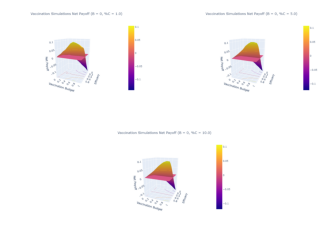

In [118]:
B3 = mpimg.imread("D:/Wholehouse_Simulations/Better_Vaccine_Plots/Seed_0_C_1_Net_Payoff.png") 
B5 = mpimg.imread("D:/Wholehouse_Simulations/Better_Vaccine_Plots/Seed_0_C_5_Net_Payoff.png") 
B10 = mpimg.imread("D:/Wholehouse_Simulations/Better_Vaccine_Plots/Seed_0_C_10_Net_Payoff.png")

fig = plt.figure()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42 

ax = plt.subplot2grid((2,4),(0,0), colspan=2)
ax.imshow(B3)
plt.axis("off")

ax1 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax1.imshow(B5)
plt.axis("off")

ax2 = plt.subplot2grid((2,4),(1,1), colspan=2)
ax2.imshow(B10)
plt.axis("off")

plt.savefig("D:/Wholehouse_Simulations/Subplots_Flat_Net_Payoff.jpg",bbox_inches="tight",transparent = True, dpi=500)
plt.show()

In [43]:
xlabel = "E"
ylabel = "VB"
zlabel = "%total"
filename = "D:/Wholehouse_Simulations/Seed_0_C_10_Net_Payoff.png"
two_dose_efficacy = 0.95

Net_Payoff(xlabel, ylabel, zlabel, two_dose_efficacy, filename, df_sim_means)

In [ ]:
f1 = interpolate.interp2d(xvals_one, yvals_one, zvals_one, kind='cubic')
f2 = interpolate.interp2d(xvals_two, yvals_two, zvals_two, kind='cubic')
X = np.linspace(0, 1, 5000)
Y = np.linspace(0, 1, 5000)

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
X = np.linspace(0, 1, 5000)
Y = np.linspace(0, 1, 5000)

scale_x = 1
scale_y = 1
scale_z = 0.0

#ax.plot_surface(X, Y, f1(X, Y) - f2(X, Y), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
#ax.plot_surface(X, Y, f1(X, Y), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
#ax.plot_surface(X, Y, f2(X, Y), rstride=1, cstride=1, cmap = cm.viridis, antialiased=False, alpha = 0.5)
#ax.contour(X, Y, f1(X, Y) - f2(X, Y), zdir='z', offset=-2, levels = [0])
ax.contour(X, Y, f1(X, Y) - f2(X, Y), levels = [0])
ax.set_zlim(zmin = -0.0)
ax.set_zlim(zmax = 0.0)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([scale_x, scale_y, scale_z, 1]))
ax.w_zaxis.line.set_lw(0.0)
ax.set_zticks([])
ax.set_xlabel("Efficacy")
ax.set_ylabel("Vaccination Budget")
ax.set_zlabel("Attack Rate")
ax.set_title("Contour Curve of Intersection between 1- and 2-Dose Strategies")
plt.savefig("D:/Wholehouse_Simulations/What_Did_I_Just_Do.png")


In [ ]:
# Do some basic statistical analysis
df_stats = statistics(df_new, param, key, ylabel) 
df_stats